In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
plt.style.use('seaborn')

df = pd.read_csv("kc_house_data.csv")

## Ideas/Thoughts:
 - yr_renovated is currently a float - should be int, with NaN converted to 0
 - 2376 null waterfront values - should convert to 0?? also waterfront is float not int
 - sqft_basement is float, but other 3 sqft columns are int
 - sqft_basement has ? as null values (can derive this from sqft_living = sqft_above + sqft_basement)
 - total sqft = sqft_living + sqft_lot ??
 - house id 2402100895 says it has 33 bedrooms (appears to be a dentist's office, via google maps?)
 - have both 0 and NaN as nulls in yr_renovated (17011 have 0, 3842 have NaN)
 
## To Do:
 - plot prices vs category of view or condition (think factor plots, https://elitedatascience.com/python-seaborn-tutorial)
 - consider dropping yr_renovated and waterfront b/c sheer number of nulls
 - use some kind of iteration to go through and replace the ? values in sqft_basement to (sqft_living - sqft_above)


## Meaningful Questions:
1. What is the single strongest predictor for price?
2. Is zipcode highly correlated with price?
3. How is date correlated to the price at which the house was sold?

**4. Does the grade of the house impact the price, when controlling for size?**
5. Does the age of the house impact the price, when controlling for size?

**6. For the homes where we have data on the last year renovated, does it have a similar impact as age?**
7. Which impacts price more, impact or grade?
8. Do the highest quality homes (by grade/condition) have a minimum price at which they sell?
9. Do newer homes have more bedrooms and bathrooms, or are generally bigger, than older homes?
10. Does the size of nearby homes impact the size or price of a home?

**11. Does paying more for a house get you more quantity (bedrooms, bathrooms, sqft) or quality (condition, grade)?**

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

In [47]:
df[["date"]].scatter(figsize  = [6, 6])

AttributeError: 'DataFrame' object has no attribute 'scatter'

In [12]:
df.size

453537

In [14]:
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [26]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [ ]:
clean_df = df.fillna(va,

In [ ]:
clean_df['waterfront'] = clean_df['waterfront'].apply(np.int64)

In [ ]:
df['waterfront'].value_counts()

In [ ]:
clean_df = clean_df.fillna(clean_df['yr_renovated'].median())

In [ ]:
clean_df['yr_renovated'] = clean_df['yr_renovated'].apply(np.int64)

In [ ]:
def column_float_to_int(df, column):
    df[column] = df[column].apply(np.int64)

In [27]:
df['date'] = pd.to_datetime(df['date'])

In [32]:
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,2015-01-15,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,2015-04-15,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,2015-03-12,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [ ]:
clean_df.head()

In [ ]:
sqft_df = df.filter(["sqft_living", "sqft_lot", "sqft_above", "sqft_basement"], axis=1)

In [ ]:
sqft_df.dtypes

In [ ]:
print(len(df.id))

In [ ]:
print(len(set(df.id)))

In [ ]:
df.columns

In [ ]:
clean_df.dtypes

In [ ]:
df['zipcode'].unique()

In [ ]:
df.sort_values(by = 'bedrooms', ascending = False)

In [2]:
# Looking at location-focused independent variables
formula_loc = "price ~ waterfront+view+lat+long+zipcode+sqft_living15+sqft_lot15"
model_loc = ols(formula= formula_loc, data=df).fit()
model_loc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     2848.
Date:                Sun, 05 May 2019   Prob (F-statistic):               0.00
Time:                        11:27:18   Log-Likelihood:            -2.6611e+05
No. Observations:               19164   AIC:                         5.322e+05
Df Residuals:                   19156   BIC:                         5.323e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.844e+07   3.69e+06     -7.701      0.000   -3.57e+07   -2.12e+07
waterfront     6.496e+05   2.37e+04     27.395      0.000    6.03e+05    6.96e+05
view           8.692e+04   2852.994     30.466      0.000    8.13e+04    9.25e+04
lat              7.6e+05   1.42e+04     53.358      0.000    7.32e+05    7.88e+05
long           -3.91e+05    1.7e+04    -23.039      0.000   -4.24e+05   -3.58e+05
zipcode        -566.2776     44.436    -12.744      0.000    -653.376    -479.180
sqft_living15   287.2252      3.151     91.149      0.000     281.049     293.402
sqft_lot15        0.2130      0.071      2.996      0.003       0.074       0.352
==============================================================================
Omnibus:                    18877.070   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2686956.042
Skew:                           4.465   Prob(JB):                         0.00
Kurtosis:                      60.317   Cond. No.                     1.95e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
df["date"].head(20)

0    2014-10-13
1    2014-12-09
2    2015-02-25
3    2014-12-09
4    2015-02-18
5    2014-05-12
6    2014-06-27
7    2015-01-15
8    2015-04-15
9    2015-03-12
10   2015-04-03
11   2014-05-27
12   2014-05-28
13   2014-10-07
14   2015-03-12
15   2015-01-24
16   2014-07-31
17   2014-05-29
18   2014-12-05
19   2015-04-24
Name: date, dtype: datetime64[ns]

In [37]:
# The below code doesn't work! date needs to be reformatted - so, we should 
# definitely add a unix time column, will also need to check this format

#Looking at time-focused variables
formula_time = "price ~ date+yr_built+yr_renovated"
model_time = ols(formula= formula_time, data=df).fit()
model_time.summary()

In [36]:
#Looking at house quality-focused variables
formula_qual = "price ~ bedrooms+bathrooms+floors+view+waterfront+grade+condition"
model_qual = ols(formula= formula_qual, data=df).fit()
model_qual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     3302.
Date:                Sun, 05 May 2019   Prob (F-statistic):               0.00
Time:                        12:57:16   Log-Likelihood:            -2.6536e+05
No. Observations:               19164   AIC:                         5.307e+05
Df Residuals:                   19156   BIC:                         5.308e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.151e+06   1.77e+04    -65.170      0.000   -1.19e+06   -1.12e+06
bedrooms    1.227e+04   2295.633      5.344      0.000    7767.260    1.68e+04
bathrooms   7.077e+04   3629.303     19.499      0.000    6.37e+04    7.79e+04
floors     -3.346e+04   4081.120     -8.199      0.000   -4.15e+04   -2.55e+04
view         8.13e+04   2684.901     30.281      0.000     7.6e+04    8.66e+04
waterfront  6.258e+05   2.28e+04     27.430      0.000    5.81e+05    6.71e+05
grade       1.713e+05   2140.326     80.052      0.000    1.67e+05    1.76e+05
condition   6.317e+04   2894.985     21.820      0.000    5.75e+04    6.88e+04
==============================================================================
Omnibus:                    16528.022   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1673650.795
Skew:                           3.651   Prob(JB):                         0.00
Kurtosis:                      48.196   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
df.loc[df["sqft_basement"] == "?"].apply(lambda x: x['sqft_living'] - x['sqft_above'], axis=1)

6           0
18          0
42          0
79          0
112       380
115      1600
217         0
309      1100
384      1320
508       720
633       560
645       610
664         0
671       850
685         0
755       530
881         0
890         0
995         0
1073      200
1105        0
1205      970
1354        0
1356        0
1366        0
1476        0
1558      480
1600      840
1662      530
1669        0
         ... 
20275       0
20333       0
20510     200
20553       0
20554     200
20676       0
20702     530
20741       0
20766     630
20853       0
20903       0
20929       0
20931       0
20934     390
20992       0
21000     120
21017       0
21087       0
21109     870
21210     100
21236       0
21248       0
21356    1180
21357       0
21365       0
21442     970
21447       0
21473       0
21519       0
21581       0
Length: 454, dtype: int64

In [21]:
outcome = "price"
qual_columns = ["bedrooms", "bathrooms", "floors", "view", "waterfront", "grade", "condition"]
loc_columns = ["waterfront", "view", "lat", "long", "zipcode", "sqft_living15", "sqft_lot15"]
time_columns = ["date", "yr_built", "yr_renovated"]

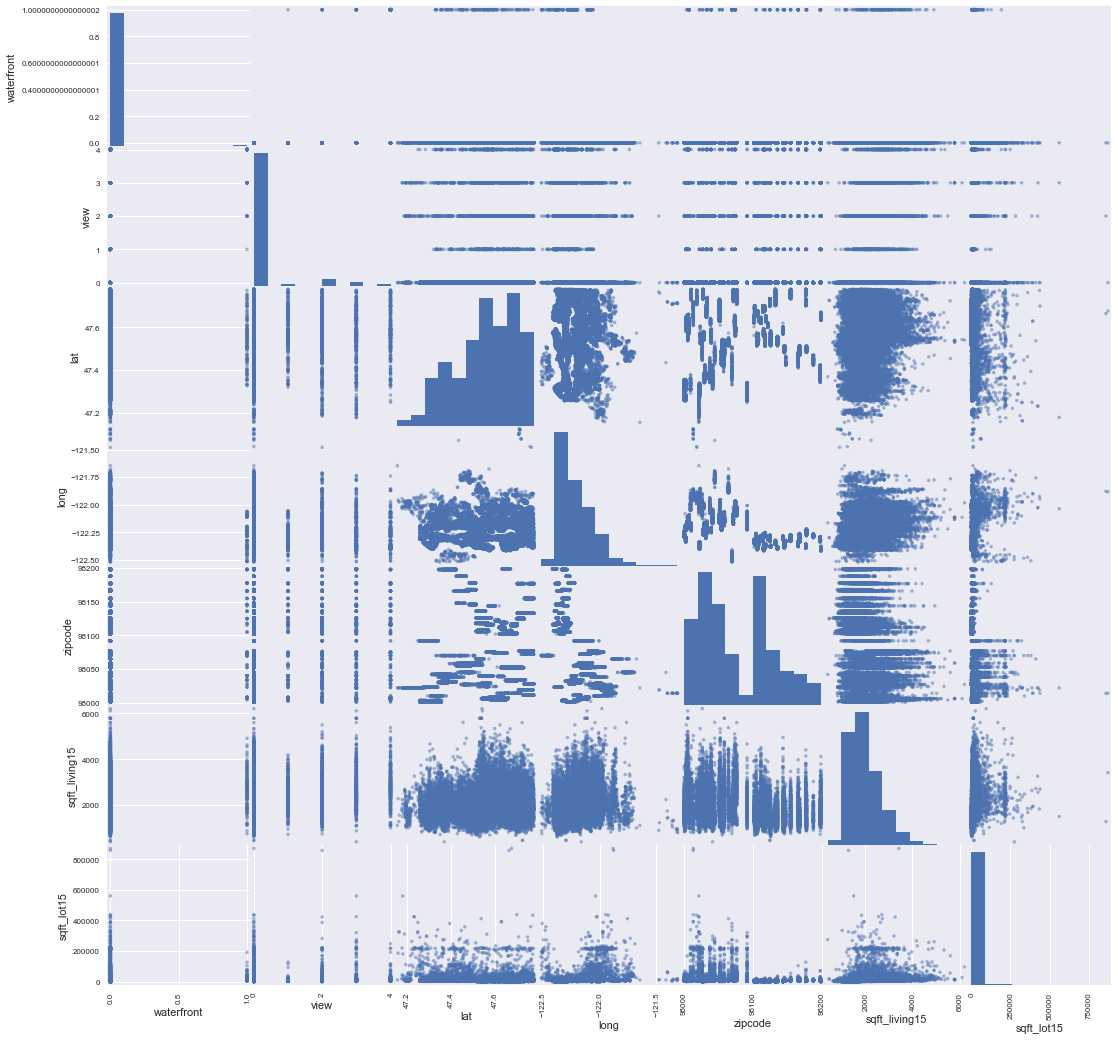

In [38]:
pd.plotting.scatter_matrix(df[loc_columns], figsize=(18,18));